# Phase 3: Baseline Modeling

In this notebook, I build baseline machine learning models for sentiment classifications using the cleaned IMDB dataset.

**Objectives**
- Convert test reviews into numeric features using Bag-of-Words and TF-IDF vectorization.
- Train baseline models (Logistic Regression. Linear SVM, Naive Bayes.)
- Evaluate models with accuracy, precision, recall, F1 score, and confusion matrices.
- Compare Compare approaches to identify the strongest baseline before moving into deep learning models in the next phase.

This will establish a reference performance that future, more complex models must beat.

In [23]:
# Imports
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
# Load the cleaned csv
df = pd.read_csv("../data/imdb_reviews_clean.csv")
print(df.shape)
df.head(5)

(50000, 5)


,review,label,split,word_count,tokens
0,bromwell high is a cartoon comedy. it ran at t...,pos,train,140,"['bromwell', 'high', 'is', 'a', 'cartoon', 'co..."
1,homelessness (or houselessness as george carli...,pos,train,420,"['homelessness', '(or', 'houselessness', 'as',..."
2,brilliant over-acting by lesley ann warren. be...,pos,train,147,"['brilliant', 'over-acting', 'by', 'lesley', '..."
3,this is easily the most underrated film inn th...,pos,train,124,"['this', 'is', 'easily', 'the', 'most', 'under..."
4,this is not the typical mel brooks film. it wa...,pos,train,120,"['this', 'is', 'not', 'the', 'typical', 'mel',..."


In [3]:
# split the data frame into training and testing data
train_df = df[df["split"] == "train"]
test_df = df[df["split"] == "test"]

print(train_df.shape)
print(test_df.shape)

X_train = train_df["review"]
y_train = train_df["label"]
X_test = test_df["review"]
y_test = test_df["label"]

print(f"y_train value count: {y_train.value_counts()}")
print(f"y_test value count: {y_test.value_counts()}")

# Random review print
sample_train = train_df.sample(n=1, random_state=42)
print(f"Random train review: {sample_train['review'].values[0][:100]}")
print(f"Label: {sample_train['label'].values[0]}")

sample_test = test_df.sample(n=1, random_state=99)
print(f"Random test review: {sample_test['review'].values[0][:100]}")
print(f"Label: {sample_test['label'].values[0]}")

(25000, 5)
(25000, 5)
y_train value count: label
pos    12500
neg    12500
Name: count, dtype: int64
y_test value count: label
pos    12500
neg    12500
Name: count, dtype: int64
Random train review: in panic in the streets richard widmark plays u.s. navy doctor who has his week rudely interrupted w
Label: pos
Random test review: this movie is a pile of rubbish , and to try and base it the first is just a farce , the main thing 
Label: neg


## Experiment 1: TF-IDF + Logistic Regression

### Hypothesis
TF-IDF with uni+bi-grams will outperform raw counts because it down-weights ubiquitous terms and highlights discriminative phrases.

### Settings
- Vectorizer: TF-IDF, n-grams (1,2), min_df=2, max_df=0.9
- Model: Logistic Regression, C=1.0, solver=liblinear (or saga), random_state=42
- Notes: keep default class weights first; revisit if imbalance emerges (it shouldn’t here).

### Protocol (to avoid leakage)
Fit TF-IDF only on train, evaluate on test via a single pipeline object.

### What to capture
- Train time (approx)
- Test accuracy
- Precision/Recall/F1 (per class + macro)
- Confusion matrix
- Brief summary

### Pass/Fail Criteria
Baseline target ≥ 85% accuracy. If below, inspect preprocessing/vectorizer params.

In [6]:
# Make a Pipeline
# tfidf applied TF-IDF with uni+bi-grams, ignores super-rare and overly common words
# clf runs Logistic Regression with:
#   standard regularization strength of 1.0
#   liblinear solver for efficient binary classification
#   random state set to 42 for reproducibility

tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)),
    ("clf", LogisticRegression(C=1.0, solver="liblinear", random_state=42))
])

In [ ]:
# Fit the pipeline and record time to fit training data

start_time = time.perf_counter()
tfidf_lr.fit(X_train, y_train)
end_time = time.perf_counter()
time_elapsed = end_time-start_time

print(f"Time elapsed: {time_elapsed:.2f} seconds.")

Time elapsed: 5.65 seconds.


In [10]:
# Predict
Y_hat = tfidf_lr.predict(X_test)

In [11]:
# Show the accuracy of y vs yhat
accuracy = accuracy_score(y_true=y_test, y_pred=Y_hat)
print(f"The accuracy (# of correct predictions / total # of predictions) is {accuracy*100:.2f}%.")

The accuracy (# of correct predictions / total # of predictions) is 89.10%.


In [12]:
# Classification Report:
#   Precision -> Of all the reviews I predicted as positive, how many really were positive?
#   Recall -> Of all the truly positive reviews, how many did I successfully find?
#   F1 Score -> How well do precision and recall balance each other?

class_rep = classification_report(y_true=y_test, y_pred=Y_hat)
print(class_rep)

              precision    recall  f1-score   support

         neg       0.89      0.89      0.89     12500
         pos       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [13]:
# Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=Y_hat)
print(cm)

[[11079  1421]
 [ 1303 11197]]


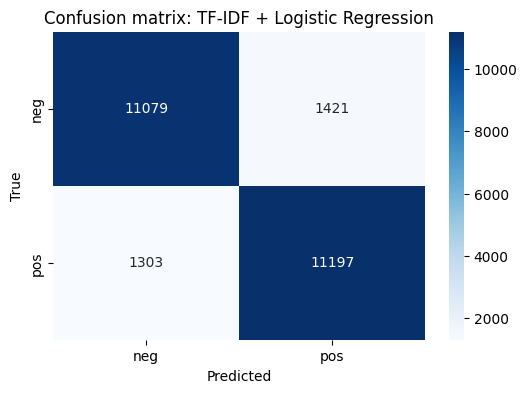

In [14]:
# CM Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg", "pos"], yticklabels=["neg", "pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix: TF-IDF + Logistic Regression")
plt.show()

## Results: TF-IDF + Logistic Regression
- Accuracy: 89.10%
- Precision, Recall, F1: All balanced at 0.89 for both positive and negative classes
- Confusion Matrix: 22,276 correctly classified reviews; 1421 false positives and 1303 false negatives.

The errors are balanced showing the model does not favor one class.

TF+IDF with uni+bi-grams combined with Logistic Regression provides a strong classical baseline for sentiment classification. The model is both accurate and balanced, handling positive and negative reviews equally well. This result is a solid benchmark to compare against deep learning apporaches in later experiments.

## Experiment 2: Linear SVM

In [16]:
# Pipeline with TF-IDF vectorization and LinearSVC classifier
tfidf_lsvm = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)),
    ("clf", LinearSVC(random_state=42))
])

In [17]:
# Fit the pipeline and record time to fit training data

start_time = time.perf_counter()
tfidf_lsvm.fit(X_train, y_train)
end_time = time.perf_counter()
time_elapsed = end_time-start_time

print(f"Time elapsed: {time_elapsed:.2f} seconds.")

Time elapsed: 5.42 seconds.


In [18]:
# Predict
Y_hat_lsvm = tfidf_lsvm.predict(X_test)

In [ ]:
# Show the accuracy of y vs yhat
accuracy_lsvm = accuracy_score(y_true=y_test, y_pred=Y_hat_lsvm)
print(f"The accuracy (# of correct predictions / total # of predictions) is {accuracy_lsvm*100:.2f}%.")

The accuracy (# of correct predictions / total # of predictions) is 90.16%.


In [20]:
# Classification Report:

class_rep_lsvm = classification_report(y_true=y_test, y_pred=Y_hat_lsvm)
print(class_rep_lsvm)

              precision    recall  f1-score   support

         neg       0.90      0.90      0.90     12500
         pos       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



In [21]:
# Confusion matrix
cm_lsvm = confusion_matrix(y_true=y_test, y_pred=Y_hat_lsvm)
print(cm_lsvm)

[[11311  1189]
 [ 1271 11229]]


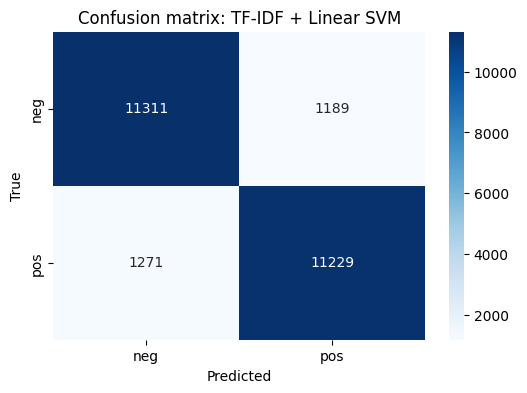

In [22]:
# CM Heatmap lsvm
plt.figure(figsize=(6,4))
sns.heatmap(cm_lsvm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg", "pos"], yticklabels=["neg", "pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix: TF-IDF + Linear SVM")
plt.show()

## Results: TF-IDF + Linear SVM

- Accuracy: 90.16%
- Precision, Recall, F1: All 0.90 for both positive and negative classes
- Confusion Matrix: True Negatives: 11,311, False Positives: 1,189, False Negatives: 1,271, True Positives: 11,229

Linear SVM improves upon Logistic Regression, pushing accuracy above 90%. Both classes are treated equally well, with balanced precision, recall, and F1 scores. The confusion matrix confirms balanced performance, with roughly equal false positives and false negatives. This result sets Linear SVM as the strongest classical baseline so far.

## Experiment 3: TF-IDF + Multinomial Naive Bayes

In [24]:
# Pipeline with TF-IDF vectorization and Multinomal Naive Bayes classifier
tfidf_mnb = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)),
    ("clf", MultinomialNB(alpha=1.0))
])

In [ ]:
# Fit the data
start_time = time.perf_counter()
tfidf_mnb.fit(X_train, y_train)
end_time = time.perf_counter()
print(f"Time elapsed: {end_time-start_time:.2f} seconds.")

Time elapsed: 5.05 seconds.


In [26]:
# Predict
Y_hat_mnb = tfidf_mnb.predict(X_test)

In [27]:
# Show the accuracy of y vs yhat
accuracy_mnb = accuracy_score(y_true=y_test, y_pred=Y_hat_mnb)
print(f"The accuracy (# of correct predictions / total # of predictions) is {accuracy_mnb*100:.2f}%.")

The accuracy (# of correct predictions / total # of predictions) is 86.78%.


In [28]:
# Classification Report:

class_rep_mnb = classification_report(y_true=y_test, y_pred=Y_hat_mnb)
print(class_rep_mnb)

              precision    recall  f1-score   support

         neg       0.84      0.91      0.87     12500
         pos       0.90      0.83      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [29]:
# Confusion matrix
cm_mnb = confusion_matrix(y_true=y_test, y_pred=Y_hat_mnb)
print(cm_mnb)

[[11362  1138]
 [ 2168 10332]]


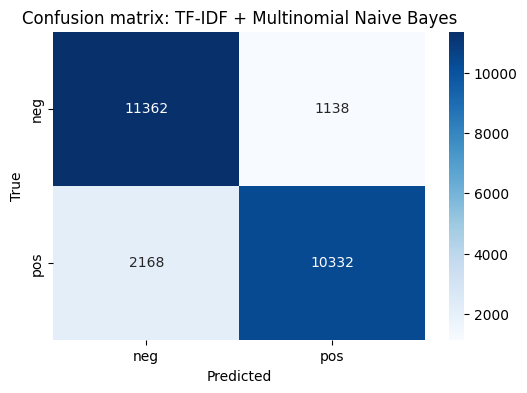

In [30]:
# CM Heatmap mnb
plt.figure(figsize=(6,4))
sns.heatmap(cm_mnb, annot=True, fmt="d", cmap="Blues", xticklabels=["neg", "pos"], yticklabels=["neg", "pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix: TF-IDF + Multinomial Naive Bayes")
plt.show()

## Experiment 3: TF-IDF + Multinomial Naive Bayes

### Hypothesis
Naive Bayes should train very fast and perform reasonably well for text classification, since it assumes conditional independence of words. However, I expect it to underperform compared to Logistic Regression and Linear SVM because IMDB reviews involve nuanced word order and phrase interactions.

### Results

-Accuracy: 86.78%

-Precision/Recall/F1: Negatives: Prec 0.84, Rec 0.91, F1 0.87 | Positives: Prec 0.90, Rec 0.83, F1 0.86

-Confusion Matrix: Shows the model tends to miss positives more often (false negatives).

-Train time: Extremely fast compared to LR/SVM.

### Summary
MNB is a strong lightweight baseline for text classification but fails to capture dependencies across words (e.g., negations like “not good”). As expected, its performance is weaker than Logistic Regression and SVM. Still, it validates that simple models can achieve nearly 87% accuracy on this dataset.

In [32]:
# Compare the experiments

# Accuracies
acc_lr   = 89.10
acc_svm  = 90.16
acc_nb   = 86.78

# Macro-F1 from the reports
f1_lr  = classification_report(y_test, Y_hat,       output_dict=True)["macro avg"]["f1-score"]
f1_svm = classification_report(y_test, Y_hat_lsvm,  output_dict=True)["macro avg"]["f1-score"]
f1_nb  = classification_report(y_test, Y_hat_mnb,   output_dict=True)["macro avg"]["f1-score"]

# Use your recorded train times
time_lr  = 5.65
time_svm = 5.42
time_nb  = 5.05

results = pd.DataFrame([
    {"Model": "TF-IDF + Logistic Regression", "Accuracy %": acc_lr,  "Macro-F1": f1_lr,  "Train Time (s)": time_lr},
    {"Model": "TF-IDF + Linear SVM",          "Accuracy %": acc_svm, "Macro-F1": f1_svm, "Train Time (s)": time_svm},
    {"Model": "TF-IDF + Multinomial NB",      "Accuracy %": acc_nb,  "Macro-F1": f1_nb,  "Train Time (s)": time_nb},
]).sort_values("Accuracy %", ascending=False)

results

,Model,Accuracy %,Macro-F1,Train Time (s)
1,TF-IDF + Linear SVM,90.16,0.901599,5.42
0,TF-IDF + Logistic Regression,89.10,0.891038,5.65
2,TF-IDF + Multinomial NB,86.78,0.867535,5.05


### Classical Baselines: Summary

Across three classical models trained on TF-IDF features, **Linear SVM** achieved the best performance:

- **Linear SVM:** 90.16% accuracy, macro-F1 ~ 0.90
- **Logistic Regression:** 89.10% accuracy, macro-F1 ~ 0.89
- **Multinomial Naive Bayes:** 86.78% accuracy, macro-F1 ~ 0.87 (fastest to train)

**Takeaways**

SVM and Logistic Regression perform very similarly on high-dimensional sparse text; SVM edged ahead by ~1pp, consistent with its large-margin optimization. Naive Bayes trains faster but underperforms due to its independence assumption, especially on phrases and negation.

**Benchmark**

We will treat **TF-IDF + Linear SVM (~90.16% accuracy)** as the baseline that any deep learning approach must beat.

# End of Phase 3

### Why I used TF-IDF and Logistic Regression, Linear SVM, Naive Bayes (MNB)
- TF-IDF highlights discriminative words by down-weighting common ones, making it a strong baseline for text classification.
- Naive Bayes (MNB): fast, probabilistic baseline for text.
- Logistic Regression (LR): interpretable, robust, widely used with sparse features.
- Linear SVM: strong classical benchmark, maximizes class separation margin

Together, they provide complementary baselines: simple (MNB), reliable (LR), and strong performer (SVM).